In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import models
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
from sklearn import metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
train_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = True,
                                          transform = transforms.ToTensor(),
                                          download = True)

test_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = False,
                                          transform = transforms.ToTensor())

In [3]:
batch_size = 100
learning_rate = 0.0003
num_epochs = 5

In [4]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle = False)

In [5]:
model = models.vgg11(pretrained= False)

#print(model)

for param in model.parameters():
    param.require_grad = False

fc = nn.Sequential(
    nn.Linear(25088,4096),nn.ReLU(inplace = True),nn.Dropout(0.5),
    nn.Linear(4096, 4096),nn.ReLU(inplace = True),nn.Dropout(0.5),
    nn.Linear(4096, 1000),nn.ReLU(inplace = True),nn.Dropout(0.5),
    nn.Linear(1000,10)
)

model.classifier = fc

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [7]:
padding = Variable(torch.zeros(100, 2, 28, 28))

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = torch.cat((images, padding), 1)
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 1.0254
Epoch [1/5], Step [200/600], Loss: 0.3571
Epoch [1/5], Step [300/600], Loss: 0.0349
Epoch [1/5], Step [400/600], Loss: 0.0842
Epoch [1/5], Step [500/600], Loss: 0.1008
Epoch [1/5], Step [600/600], Loss: 0.0489
Epoch [2/5], Step [100/600], Loss: 0.0510
Epoch [2/5], Step [200/600], Loss: 0.1023
Epoch [2/5], Step [300/600], Loss: 0.0485
Epoch [2/5], Step [400/600], Loss: 0.0665
Epoch [2/5], Step [500/600], Loss: 0.0645
Epoch [2/5], Step [600/600], Loss: 0.0330
Epoch [3/5], Step [100/600], Loss: 0.1066
Epoch [3/5], Step [200/600], Loss: 0.0111
Epoch [3/5], Step [300/600], Loss: 0.2017
Epoch [3/5], Step [400/600], Loss: 0.0094
Epoch [3/5], Step [500/600], Loss: 0.0646
Epoch [3/5], Step [600/600], Loss: 0.0447
Epoch [4/5], Step [100/600], Loss: 0.0538
Epoch [4/5], Step [200/600], Loss: 0.0051
Epoch [4/5], Step [300/600], Loss: 0.0064
Epoch [4/5], Step [400/600], Loss: 0.0371
Epoch [4/5], Step [500/600], Loss: 0.0354
Epoch [4/5], Step [600/600], Loss:

In [8]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = torch.cat((images, padding), 1)
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    pred = predicted.to('cpu')
    lb = labels.to('cpu')
    pred = np.array(pred)
    lb = np.array(lb)
    print(correct)
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

9884
Test Accuracy of the model on the 10000 test images: 98.84 %


In [9]:
confusion_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= 10000, shuffle = False)

padding = Variable(torch.zeros(10000, 2, 28, 28))

model.to('cpu')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in confusion_loader:
        images = torch.cat((images, padding), 1)
        #images = images.to(device)
        #labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    pred = predicted.to('cpu')
    lb = labels.to('cpu')
    pred = np.array(pred)
    lb = np.array(lb)

In [10]:
print(f"The Accuracy : { 100 * metrics.accuracy_score(lb, pred)}")
print(f"The Precision : {100 * metrics.precision_score(lb, pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(lb, pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(lb, pred, average = 'macro')}")

The Accuracy : 98.83999999999999
The Precision : 98.84241085115141
The Recall : 98.82994847169935
The F1 Score : 98.8318159849846


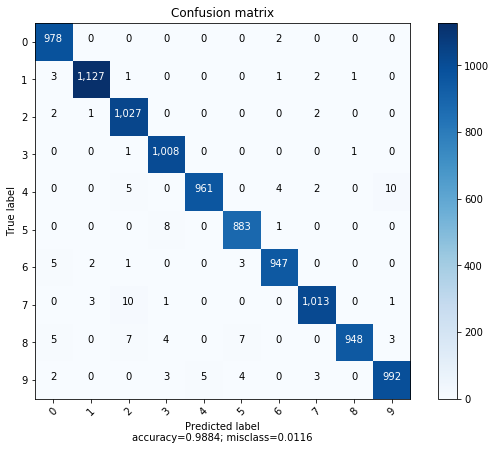

None


In [12]:
from cm_helper import plot_confusion_matrix

conf_matrix = metrics.confusion_matrix(lb, pred)
print(plot_confusion_matrix(conf_matrix,normalize =False,target_names=[0,1,2,3,4,5,6,7,8,9]))